In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt

In [3]:
# repeating the data prep from the previous notebook
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], numpy.prod(x_train[0,:,:].shape))
x_test = x_test.reshape(x_test.shape[0], numpy.prod(x_test[0,:,:].shape))

print(x_train.shape)
y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

print()
print('MNIST data loaded: train:',len(x_train),'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)

# one-hot encoding:
nb_classes = 10
y_train_onehot = tf.keras.utils.to_categorical(y_train, nb_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, nb_classes)

(60000, 28, 28)
(60000, 784)

MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 784)
y_train: (60000,)


In [4]:
# Here we import an implementation of a two-layer neural network 
# this code is based on pieces of the first assignment from Stanford's CSE231n course, 
# hosted at https://github.com/cs231n/cs231n.github.io with the MIT license
from fc_net import TwoLayerNet

In [5]:
num_features = x_train.shape[1] # this is the number of pixels
# The weights are initialized from a normal distribution with standard deviation weight_scale
model = TwoLayerNet(input_dim=num_features, hidden_dim=300, num_classes=nb_classes, weight_scale=.01)

In [6]:
# here you can take a look if you want at the initial loss from an untrained network
loss, gradients = model.loss(x_train, y_train_onehot)

In [7]:
# a simple implementation of stochastic gradient descent
def sgd(model, gradients, learning_rate):
    for p, w in model.params.items():
        dw = gradients[p]
        new_weights = w - learning_rate * dw
        model.params[p] = new_weights
    return model

In [8]:
# one training step
def learn(model, x_train, y_train_onehot, learning_rate):
    loss, gradients = model.loss(x_train, y_train_onehot)
    model = sgd(model, gradients, learning_rate)
    return loss, model

In [9]:
def accuracy(model, x, true_values):
    scores = model.loss(x)
    predictions = numpy.argmax(scores, axis=1)
    N = predictions.shape[0]
    acc = (true_values == predictions).sum() / N
    return acc

epoch 0, loss 2.30087, accuracy 0.13
epoch 1, loss 2.29951, accuracy 0.16
epoch 2, loss 2.29787, accuracy 0.21
epoch 3, loss 2.29651, accuracy 0.25
epoch 4, loss 2.29496, accuracy 0.30
epoch 5, loss 2.29323, accuracy 0.34
epoch 6, loss 2.29170, accuracy 0.38
epoch 7, loss 2.29025, accuracy 0.41
epoch 8, loss 2.28852, accuracy 0.44
epoch 9, loss 2.28690, accuracy 0.46


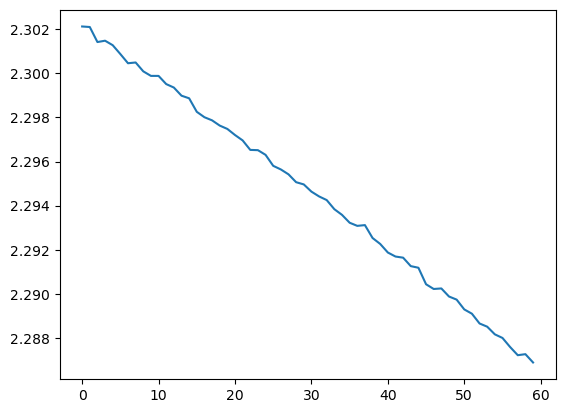

In [10]:
# Here's an example training loop using this two-layer model. Can you do better? 
learning_rate = 0.01
num_examples = x_train.shape[0]
batch_size = 10000
num_batches = int(num_examples / batch_size)
num_epochs = 10
losses = numpy.zeros(num_batches*num_epochs,)
indices = numpy.arange(num_examples)

i = 0
for epoch in range(0, num_epochs):
    # in each epoch, we loop over all of the training examples
    for step in range(0, num_batches):
        # grabbing the next batch
        offset = step * batch_size
        batch_range = range(offset, offset+batch_size)
        x_train_batch = x_train[batch_range, :]
        y_train_batch = y_train_onehot[batch_range,:]
        
        # feed the next batch in to do one sgd step
        loss, model = learn(model, x_train_batch, y_train_batch, learning_rate)
        losses[i] = loss
        i += 1

    acc = accuracy(model, x_train, y_train)
    print("epoch %d, loss %.5f, accuracy %.2f" % (epoch, loss, acc))
    
    # reshuffle the data so that we get a new set of batches
    numpy.random.shuffle(indices)
    x_train = x_train[indices,:]
    y_train = y_train[indices] # keep this shuffled the same way for use in accuracy calculation
    y_train_onehot = y_train_onehot[indices,:]
plt.plot(losses)

In [11]:
accuracy(model, x_test, y_test)

0.4661

# Homework: improve the accuracy of this model. 

Update this notebook so that the accuracy is improved. How high can you get it? You could change things directly in the notebook, such as increasing the number of epochs, changing the learning weight, changing the width of the hidden layer, etc. If you're more ambitious, you could also try changing the model definition itself by checking out the associated Python files. For example, you could add more layers to the network. The current notebook has a training accuracy of about 43%, but will vary with randomness.

# Solution
Part of the reason that the accuracy is low is because we haven't trained the model very much. Some quick changes to increase accuracy up to ~88%:

 - *Decrease batch size by a factor of 20*. This gives 20 times as many batches in an epoch, which leads to 20 times as many updates to the model parameters in each epoch. The number of operations needed per epoch remains the same. The downside is that this increases the variance of the SGD update, so training behavior may be slightly more erratic. In practice it seems that batches are still large enough to avoid this.
 - *Double the number of epochs*. This increases the number of times we update the parameters, without affecting the variane of the update. It does double the number of training operations, though.

With this the accuracy of the trained model levels off at around 88% after 15 epochs. To get a bit further:

 - *Double the learning rate.* This allows the model to reach the same accuracy in about 8 epochs, and by epoch 20 the accuracy is closer to 91%. There is an upper limit to this strategy, and pushing the rate too high will cause erratic training behavior.

Finally, with 40 epochs (4x the original value) of training at an even higher learning rate of 0.05 (5x the original value), the accuracy reaches 95%. Returns are greatly diminishing at this point: the first 5 epochs take us to 90%, while the last 35 are responsible for 5% more accuracy.

epoch 0, loss 1.41470, accuracy 0.72
epoch 1, loss 0.66254, accuracy 0.84
epoch 2, loss 0.52483, accuracy 0.87
epoch 3, loss 0.48064, accuracy 0.88
epoch 4, loss 0.47385, accuracy 0.89
epoch 5, loss 0.41408, accuracy 0.90
epoch 6, loss 0.29835, accuracy 0.90
epoch 7, loss 0.37411, accuracy 0.91
epoch 8, loss 0.30089, accuracy 0.91
epoch 9, loss 0.34321, accuracy 0.91
epoch 10, loss 0.28757, accuracy 0.91
epoch 11, loss 0.30578, accuracy 0.92
epoch 12, loss 0.31598, accuracy 0.92
epoch 13, loss 0.26595, accuracy 0.92
epoch 14, loss 0.31387, accuracy 0.92
epoch 15, loss 0.30881, accuracy 0.93
epoch 16, loss 0.24938, accuracy 0.93
epoch 17, loss 0.24441, accuracy 0.93
epoch 18, loss 0.21931, accuracy 0.93
epoch 19, loss 0.25800, accuracy 0.93
epoch 20, loss 0.22096, accuracy 0.93
epoch 21, loss 0.21830, accuracy 0.93
epoch 22, loss 0.24990, accuracy 0.94
epoch 23, loss 0.22773, accuracy 0.94
epoch 24, loss 0.19886, accuracy 0.94
epoch 25, loss 0.22610, accuracy 0.94
epoch 26, loss 0.25298

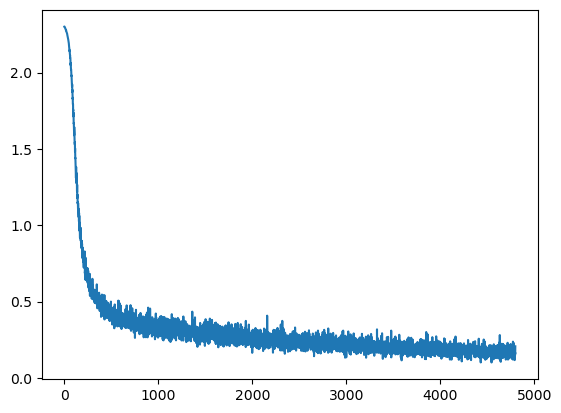

In [12]:
# Start with a fresh model
better_model = TwoLayerNet(input_dim=num_features, hidden_dim=300, num_classes=nb_classes, weight_scale=.01)

# More aggressive training parameters
learning_rate = 0.05
num_examples = x_train.shape[0]
batch_size = 500
num_batches = int(num_examples / batch_size)
num_epochs = 40
losses = numpy.zeros(num_batches*num_epochs,)
indices = numpy.arange(num_examples)

i = 0
for epoch in range(0, num_epochs):
    # in each epoch, we loop over all of the training examples
    for step in range(0, num_batches):
        # grabbing the next batch
        offset = step * batch_size
        batch_range = range(offset, offset+batch_size)
        x_train_batch = x_train[batch_range, :]
        y_train_batch = y_train_onehot[batch_range,:]
        
        # feed the next batch in to do one sgd step
        loss, better_model = learn(better_model, x_train_batch, y_train_batch, learning_rate)
        losses[i] = loss
        i += 1

    acc = accuracy(better_model, x_train, y_train)
    print("epoch %d, loss %.5f, accuracy %.2f" % (epoch, loss, acc))
    
    # reshuffle the data so that we get a new set of batches
    numpy.random.shuffle(indices)
    x_train = x_train[indices,:]
    y_train = y_train[indices] # keep this shuffled the same way for use in accuracy calculation
    y_train_onehot = y_train_onehot[indices,:]
plt.plot(losses)

print("Final model accuracy on test data: %f" % (accuracy(better_model, x_test, y_test)))